## Homework 3


# DISCLAIMER: to visualize our maps, please go to [notebook viewer](https://nbviewer.jupyter.org/github/brunebastide/ADA/blob/master/homework03/homework3.ipynb)

## Table of Contents

### [Question 1](#1.-Eurostat)


### [Question 2](#2.-Amstat-unemployment-and-job-seekers-in-Switzerland)


### [Question 3](#3.-Unemployment-rate-between-Swiss-and-Foreign-workers)



In [2]:
import os
import pandas as pd
import json
import folium
import branca
import math
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Eurostat
Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

Use this data to build a Choropleth map which shows the unemployment rate in Europe at a country level. 
Think about the colors you use, how you decided to split the intervals into data classes or which interactions you could add in order to make the visualization intuitive and expressive. 
Compare Switzerland's unemployment rate to that of the rest of Europe.

### Load data from eurostat
We downloaded the unemployment dataset from eurostat for the past nine years. After converting the file to CSV for encoding reasons and cleaning the useless columns, we can start our analysis of the European unemployment rate. If you take a look at the csv file you will notice that the missing rates are assigned to the value `:` which we replaced by `NaN`.

In [3]:
#load csv file of second dataset 
eurostat2_data = pd.read_excel('eurostat/eurostat2.xls', header=3, skip_footer=8, na_values=':')

We will only keep the last column of our dataset as the most recent unemployemnt rates are what we will focus on. This corresponds to unemployment rate for the year 2016.

In [4]:
eurostat2_data = eurostat2_data.iloc[:,[0,-1]]
eurostat2_data.columns = ['Country', 'Rate']
eurostat2_data = eurostat2_data.set_index(['Country'])
eurostat2_data.tail(10)

,Rate
Country,
Liechtenstein,NaN
Norway,4.7
Switzerland,3.3
Montenegro,NaN
"Former Yugoslav Republic of Macedonia, the",NaN
Albania,NaN
Serbia,NaN
Turkey,10.9
United States,4.9


Some values are meaningless as they are not part of Europe, we will drop them.

In [5]:
eurostat2_data = eurostat2_data.dropna()

### Load data from TopoJSON

Now that we have the necessary information to build our map we will use the topojson file to map the unemployments rates to each country on our map.

In [6]:
eu_json_path = r'topojson/europe.topojson.json'
eu_json_data = json.load(open(eu_json_path))
elements = eu_json_data['objects']['europe']['geometries']
countries = [c['properties']['NAME'] for c in elements]
countries.sort()

The following `NaN` values correspond to some of the countries in topojson for which no unemployment rate is listed.

In [7]:
eurostat2_data = eurostat2_data.loc[countries]
eurostat2_data.head(10)

,Rate
Country,
Albania,NaN
Andorra,NaN
Armenia,NaN
Austria,6.0
Azerbaijan,NaN
Belarus,NaN
Belgium,7.8
Bosnia and Herzegovina,NaN
Bulgaria,7.6


We define a color scale and a style to show the unemployment rate in Europe. Note that countries for which we don't have an unemployment rate are transparent. We chose the color red to display the unemployement rates in this homework to stress the negative impact of a high unemployment rate over a country's well-being.

In [8]:
def unemployed_color_scale(max_):
    colorscale = branca.colormap.linear.YlOrRd.scale(0, max_)
    colorscale.caption = "Unemployment rate (%)"
    return colorscale


To visualize our maps: [notebook viewer](https://nbviewer.jupyter.org/github/brunebastide/ADA/blob/master/homework03/homework3.ipynb)

In [9]:
eu_map = folium.Map(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}', attr='Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ')
colorscale = unemployed_color_scale(eurostat2_data['Rate'].max())

def style_function(feature):
    country = feature['properties']['NAME']
    rate = eurostat2_data.loc[country, 'Rate']
    return {
        'fillOpacity': .5 if not np.isnan(rate) else 0,
        'fillColor': colorscale(rate) if not np.isnan(rate) else 0,
        'opacity': 1 if not np.isnan(rate) else 0,
        'color': 'white',
    }

f = folium.TopoJson(
    eu_json_data, 
    'objects.europe',
    name = 'topojson',
    style_function = style_function
).add_to(eu_map)


eu_map.add_child(colorscale)
eu_map.fit_bounds(f.get_bounds())
eu_map

In [10]:
eurostat2_data[eurostat2_data.Rate == eurostat2_data.Rate.min()]

,Rate
Country,
Iceland,3.0


In [11]:
print('Mean of unemployment rate in Europe: ', eurostat2_data.dropna().Rate.mean())
print('Median of unemployment rate in Europe: ', eurostat2_data.dropna().Rate.median())

Mean of unemployment rate in Europe:  8.274999999999999
Median of unemployment rate in Europe:  7.25


We can observe that the minimum unemployment rate in Europe (excluding the missing countries) is reached in Iceland with a rate of 3%. Switzerland is not far away to reach that minimum as its rate of unemployment was 3.3% for the year 2016. Moreover, the overall rate of unemployment in Europe is more than twice Switzerland's, which is an expected result.

## 2. Amstat unemployment and job seekers in Switzerland

We downloaded the unemployment dataset from [amstat](https://www.amstat.ch/v2/index.jsp?lang=fr) for the month of September 2017. After converting the file to CSV for encoding reasons and cleaning the useless columns, we can start our analysis of the Swiss unemployment rate. We translate all the columns field to have them in English.

In [12]:
cantons_topojson = './topojson/ch-cantons.topojson.json'
data_path = './amstat/dataset-q1.csv'

with open(data_path, 'r') as f:
    amstat_seekers = pd.read_csv(f, thousands="'", na_values='...')

amstat_seekers = amstat_seekers.loc[:25,:]  # remove total row
amstat_seekers.columns = ['canton', 'unemployment_rate', 'registered_unemployed', 'job_seekers', 'non_unemployed_job_seekers']
amstat_seekers
amstat_seekers['active_population'] = \
    (amstat_seekers['job_seekers'] * 100 / amstat_seekers['unemployment_rate']).astype('int64')
amstat_seekers = amstat_seekers.set_index(['canton'])
amstat_seekers.head(10)

,unemployment_rate,registered_unemployed,job_seekers,non_unemployed_job_seekers,active_population
canton,,,,,
Zurich,3.3,27225,34156,6931,1035030
Berne,2.4,13658,18385,4727,766041
Lucerne,1.7,3885,6756,2871,397411
Uri,0.6,112,257,145,42833
Schwyz,1.7,1455,2229,774,131117
Obwald,0.7,153,319,166,45571
Nidwald,1.0,248,436,188,43600
Glaris,1.8,416,713,297,39611
Zoug,2.3,1543,2615,1072,113695


Let's find a maping between the map canton names and the unemployment data canton names. Most are correct if we order each by alphabetical order and put them together, we will fix the few errors by hand.

In [13]:
with open(cantons_topojson) as f:
    cantons_json = json.load(f)
    
cantons_map = [canton['properties']['name'] for canton in cantons_json['objects']['cantons']['geometries']]
cantons_map = sorted(cantons_map)
cantons_map2df = dict(zip(cantons_map, sorted(amstat_seekers.index.values)))

cantons_map2df['Aargau'] = 'Argovie'
cantons_map2df['Appenzell Ausserrhoden'] = 'Appenzell Rhodes-Extérieures'
cantons_map2df['Appenzell Innerrhoden'] = 'Appenzell Rhodes-Intérieures'
cantons_map2df['Basel-Landschaft'] = 'Bâle-Campagne'
cantons_map2df['Basel-Landschaft'] = 'Bâle-Campagne'
cantons_map2df['Basel-Stadt'] = 'Bâle-Ville'
cantons_map2df['Thurgau'] = 'Thurgovie'
cantons_map2df['Ticino'] = 'Tessin'

We create the Swiss map and the color scale.

In [14]:
def create_swiss_map():
    switzerland = (46.875893, 8.289321)
    return folium.Map(location=switzerland, zoom_start=8, tiles='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}', attr='Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ')

colorscale = unemployed_color_scale(6)

In [14]:
m = create_swiss_map()
m.add_child(colorscale)

def style_function(canton, df_field):
    canton_name = canton['properties']['name']
    unemployment_rate = amstat_seekers.loc[cantons_map2df[canton_name], df_field]
    return {
        'fillOpacity': .5,
        'fillColor': colorscale(unemployment_rate),
        'opacity': 1,
        'color': 'white',
    }

cantons_poly_unemployment_rate = folium.TopoJson(
    open(cantons_topojson),
    'objects.cantons',
    name='With already employed',
    style_function=lambda c: style_function(c, 'unemployment_rate')
)
cantons_poly_unemployment_rate.add_to(m);

### Map presenting job seekers rate by canton

To visualize our maps: [notebook viewer](https://nbviewer.jupyter.org/github/brunebastide/ADA/blob/master/homework03/homework3.ipynb)

In [15]:
m

We now compute the number of job seekers who does not have a job, to differentiate with the Federal way of computing the unemployment rate.

In [16]:
amstat_seekers['unemployed_job_seekers_rate'] = \
    round(100 * (amstat_seekers["job_seekers"] - amstat_seekers['non_unemployed_job_seekers']) /  amstat_seekers['active_population'], 1)
amstat_seekers.head()

,unemployment_rate,registered_unemployed,job_seekers,non_unemployed_job_seekers,active_population,unemployed_job_seekers_rate
canton,,,,,,
Zurich,3.3,27225,34156,6931,1035030,2.6
Berne,2.4,13658,18385,4727,766041,1.8
Lucerne,1.7,3885,6756,2871,397411,1.0
Uri,0.6,112,257,145,42833,0.3
Schwyz,1.7,1455,2229,774,131117,1.1


In [17]:
m = create_swiss_map()
m.add_child(colorscale)

cantons_poly_without_employed = folium.TopoJson(
    open(cantons_topojson),
    'objects.cantons',
    name='Without already employed',
    style_function=lambda c: style_function(c, 'unemployed_job_seekers_rate')
)

cantons_poly_without_employed.add_to(m);
folium.LayerControl().add_to(m);

### Map presenting unemployed job seekers rate by canton

To visualize our maps: [notebook viewer](https://nbviewer.jupyter.org/github/brunebastide/ADA/blob/master/homework03/homework3.ipynb)

In [18]:
m

To compare more easily the impact on the statistics of job seekers already having a job, we show the following bar plot.

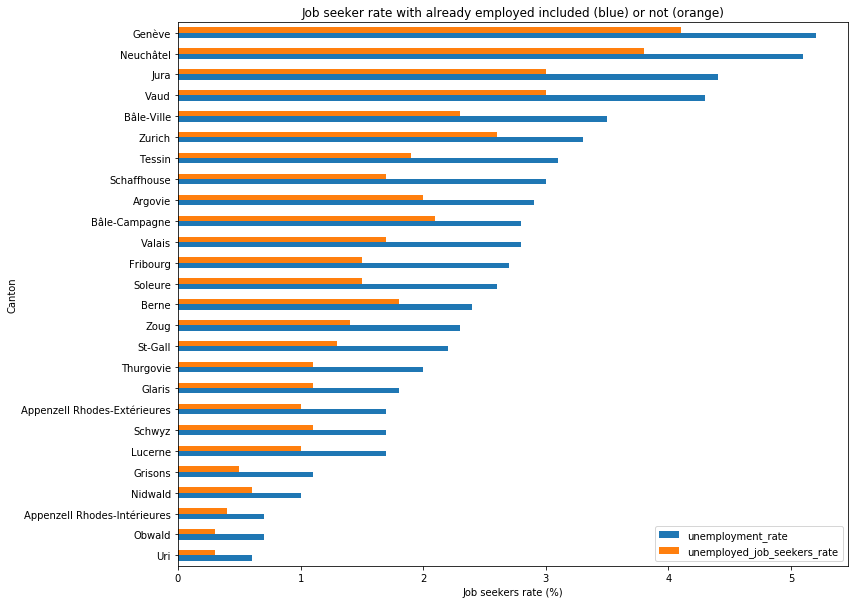

In [19]:
ax = amstat_seekers.sort_values('unemployment_rate')\
    .loc[:, ['unemployment_rate', 'unemployed_job_seekers_rate']]\
    .plot(kind='barh', figsize=(12,10));
ax.set_xlabel('Job seekers rate (%)');
ax.set_ylabel('Canton');
ax.set_title('Job seeker rate with already employed included (blue) or not (orange)');

### 3. Unemployment rate between Swiss and Foreign workers

An excel dataset that includes the unemployment rates in Switzerland is loaded from the amstat website. It contains unemployment rate, number of unemployed persons registered, coefficients of variation for each month of 2017 per canton for both swiss and foreign workers.

In [30]:
df = pd.read_excel('amstat/Taux_chomage_2017.xlsx')
df.head()

,Canton,Nationalité,Mois,Unnamed: 3,Janvier 2017,Unnamed: 5,Unnamed: 6,Février 2017,Unnamed: 8,Unnamed: 9,...,Unnamed: 23,Unnamed: 24,Août 2017,Unnamed: 26,Unnamed: 27,Septembre 2017,Unnamed: 29,Unnamed: 30,Total,Unnamed: 32
0,NaN,NaN,Mesures,Taux de chômage,Coefficients de variation,Chômeurs inscrits,Taux de chômage,Coefficients de variation,Chômeurs inscrits,Taux de chômage,...,Chômeurs inscrits,Taux de chômage,Coefficients de variation,Chômeurs inscrits,Taux de chômage,Coefficients de variation,Chômeurs inscrits,Taux de chômage,Coefficients de variation,Chômeurs inscrits
1,Zurich,Etrangers,NaN,6.6,A,15060,6.5,A,14787,6.3,...,12546,5.3,A,12151,5.3,A,12111,5.9,A,120430
2,Zurich,Suisses,NaN,2.9,A,17327,2.8,A,16832,2.8,...,15446,2.6,A,15363,2.5,A,15114,2.7,A,143239
3,Berne,Etrangers,NaN,7.5,A,6670,7.4,A,6562,7.1,...,4911,5.5,A,4913,5.5,A,4900,6.4,A,50777
4,Berne,Suisses,NaN,2.2,A,10284,2.1,A,10176,2.1,...,8722,1.9,A,8916,1.8,A,8758,2,A,83379


The dataset is processed in order to keep only interesting features, that is canton name, nationality (swiss or foreign), unemployment rates for each month and total. Number of registered unemployed persons and coefficients of variation for each month are removed.

In [31]:
# data cleaning
column_names = df.columns[list(name[0:6] != 'Unname' for name in df.columns )] 
drop_column = df.columns[list(((str(col_name)[0:4] == 'Coef') | (str(col_name)[0:2] == 'Ch')) for col_name in df.loc[0])]
df = df.drop(drop_column, axis = 1)
df.columns = column_names
df = df.drop('Mois', axis = 1)
df = df.drop(0, axis = 0)
df[df.columns.values[2:]] = df[df.columns.values[2:]].astype(np.float)
df = df.set_index('Canton')
df.head()

,Nationalité,Janvier 2017,Février 2017,Mars 2017,Avril 2017,Mai 2017,Juin 2017,Juillet 2017,Août 2017,Septembre 2017,Total
Canton,,,,,,,,,,,
Zurich,Etrangers,6.6,6.5,6.3,6.0,5.7,5.6,5.5,5.3,5.3,5.9
Zurich,Suisses,2.9,2.8,2.8,2.7,2.6,2.6,2.6,2.6,2.5,2.7
Berne,Etrangers,7.5,7.4,7.1,6.8,6.2,5.7,5.5,5.5,5.5,6.4
Berne,Suisses,2.2,2.1,2.1,2.0,1.9,1.8,1.8,1.9,1.8,2.0
Lucerne,Etrangers,5.4,5.1,4.8,4.6,4.3,4.1,3.9,3.9,3.9,4.5


We decided to create two datasets, one for foreign people and one for swiss people.

In [32]:
df_foreign = df[df.Nationalité == 'Etrangers']
df_swiss = df[df.Nationalité == 'Suisses']

The swiss cantons TopoJson file is imported

In [33]:
# import Swiss cantons topojson file
swiss_cantons = r'topojson/ch-cantons.topojson.json'
swiss_cantons_json_data = json.load(open(swiss_cantons))

The same maping as before is done between the map canton names and the unemployment data canton names. 

In [34]:
cantons_map = [canton['properties']['name'] for canton in swiss_cantons_json_data['objects']['cantons']['geometries']]
cantons_map = sorted(cantons_map)
cantons_map2df = dict(zip(cantons_map, sorted(df_foreign.index.values)))

cantons_map2df['Aargau'] = 'Argovie'
cantons_map2df['Appenzell Ausserrhoden'] = 'Appenzell Rhodes-Extérieures'
cantons_map2df['Appenzell Innerrhoden'] = 'Appenzell Rhodes-Intérieures'
cantons_map2df['Basel-Landschaft'] = 'Bâle-Campagne'
cantons_map2df['Basel-Landschaft'] = 'Bâle-Campagne'
cantons_map2df['Basel-Stadt'] = 'Bâle-Ville'
cantons_map2df['Thurgau'] = 'Thurgovie'
cantons_map2df['Ticino'] = 'Tessin'

We reuse functions to create a map showing the unemployment rate at the level of Swiss cantons:
- A colorscale is created to define the colour to use for a specific canton in terms of its unemployment rate.
- "style_function" allows to add the colorscale corresponding to unemployment rate for each canton on the swiss map.
- "map_generation" creates the swiss map, adds the TopoJson file with the style function generated by the function described above.

In [35]:
colorscale = unemployed_color_scale(9)

def style_function(canton, df_field, df_nationality):
    canton_name = canton['properties']['name']
    unemployment_rate = df_nationality.loc[cantons_map2df[canton_name], df_field]
    return {
        'fillOpacity': 0.5,
        'fillColor':colorscale(unemployment_rate),
        'opacity': 1,
        'color': 'white',
    }

def map_generation(df_field, df_nationality,map_name):
    cantons_poly = folium.TopoJson(
        swiss_cantons_json_data,
        'objects.cantons',
        name='cantons',
        style_function=lambda c: style_function(c, df_field, df_nationality)
        ).add_to(map_name)
    map_name.add_child(colorscale)
    

### September 2017 unemployment rate per canton for foreign people.

To visualize our maps: [notebook viewer](https://nbviewer.jupyter.org/github/brunebastide/ADA/blob/master/homework03/homework3.ipynb)

In [36]:
# Unemployment rate for foreign people

cantons_map_foreign = create_swiss_map()
df_field = 'Septembre 2017'
map_generation(df_field, df_foreign, cantons_map_foreign)
cantons_map_foreign

### September 2017 unemployment rate per canton for Swiss people

To visualize our maps: [notebook viewer](https://nbviewer.jupyter.org/github/brunebastide/ADA/blob/master/homework03/homework3.ipynb)

In [37]:
# Unemployment rate for swiss people
cantons_map_swiss = create_swiss_map()
df_field = 'Septembre 2017'
df_nationality = df_swiss
map_generation(df_field,df_nationality,cantons_map_swiss)
cantons_map_swiss


To show the difference in unemployment rates between foreign people and swiss people in each canton on a map, we decided to calculate the proportion of unemployed foreigners among unemployed people. Thus, a high proportion indicates that unemployment rate for foreign people is higher than the one for swiss people.

In [38]:
# Create map
m_proportion_foreigner = create_swiss_map()

# Choose the month: we have chosen the most recent date
month = 'Septembre 2017'

# Proportion of unemployed foreigners is computed 
proportion_foreigners = df_foreign[month] / (df_foreign[month] + df_swiss[month])

# Define colorscale
colorscale_foreign_proportion = branca.colormap.linear.YlGnBu.scale(0, 1)
colorscale_foreign_proportion.caption = 'Proportion of unemployed foreigners'


def style_function_proportion_foreigner(canton):
    proportion = proportion_foreigners[cantons_map2df[canton['properties']['name']]]
    return {
        'fillOpacity': 0.5,
        'fillColor': colorscale_foreign_proportion(proportion),
        'opacity': 1,
        'color': 'white',
    }


cantons_poly = folium.TopoJson(
    swiss_cantons_json_data,
    'objects.cantons',
    name='cantons',
    style_function=lambda c: style_function_proportion_foreigner(c)
    ).add_to(m_proportion_foreigner)

m_proportion_foreigner.add_child(colorscale_foreign_proportion);

### Proportion of foreigners among unemployed people per canton

To visualize our maps: [notebook viewer](https://nbviewer.jupyter.org/github/brunebastide/ADA/blob/master/homework03/homework3.ipynb)

In [39]:
m_proportion_foreigner

We can see that the more conservative cantons (like Uri) have a high proportion of unemployed foreigners. Maybe it is because foreigners are less integrated and for instance those not speaking Swiss german are unable to find a job.

*Unemployment rate between aged groups :*

In [40]:
# Load excel dataset
df_age = pd.read_excel('amstat/Taux_chomage_age.xlsx')
df_age.head()

,Canton,"Classes d'âge 15-24, 25-49, 50 ans et plus",Unnamed: 2,Mois,Unnamed: 4,Septembre 2017,Unnamed: 6,Unnamed: 7,Total,Unnamed: 9
0,NaN,NaN,NaN,Mesures,Taux de chômage,Coefficients de variation,Chômeurs inscrits,Taux de chômage,Coefficients de variation,Chômeurs inscrits
1,Zurich,1.0,15-24 ans,NaN,3.7,A,3420,3.7,A,3420
2,Zurich,2.0,25-49 ans,NaN,3.4,A,17053,3.4,A,17053
3,Zurich,3.0,50 ans et plus,NaN,2.9,A,6752,2.9,A,6752
4,Berne,1.0,15-24 ans,NaN,2.8,B,2003,2.8,B,2003


The dataset is processed in order to keep only interesting features, that is canton name, age groups and unemployment rate for september 2017. Number of registered unemployed persons and coefficients of variation are removed.

In [41]:
# Data cleaning:

column_names = ['Cantons','Age class','Septembre 2017 unemployment rate']
df_age = df_age.drop(['Classes d\'âge 15-24, 25-49, 50 ans et plus','Mois','Septembre 2017','Unnamed: 6','Unnamed: 7','Total','Unnamed: 9' ], axis = 1)
df_age.columns = column_names
df_age = df_age.drop([0,79],axis = 0)
df_age.head()

,Cantons,Age class,Septembre 2017 unemployment rate
1,Zurich,15-24 ans,3.7
2,Zurich,25-49 ans,3.4
3,Zurich,50 ans et plus,2.9
4,Berne,15-24 ans,2.8
5,Berne,25-49 ans,2.5


A bar plot is created to visualize unemployment rate per age group for each canton.

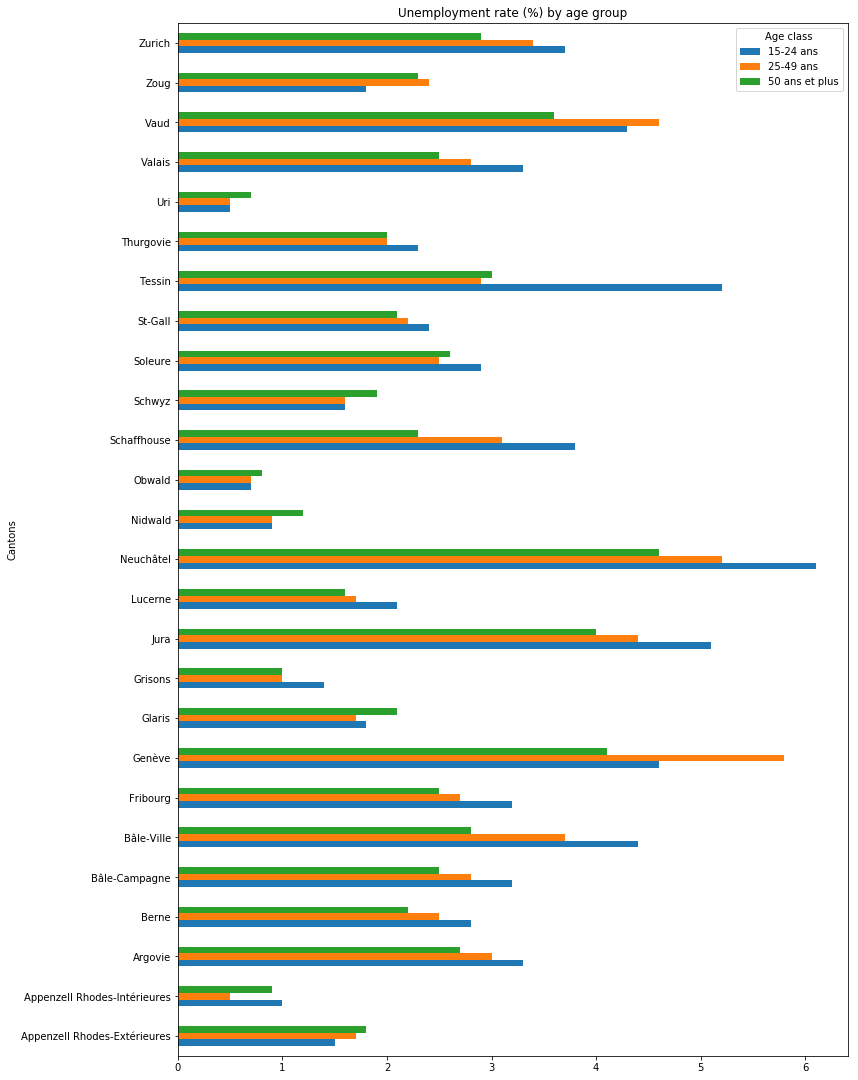

In [42]:
df_age['Septembre 2017 unemployment rate'] = df_age['Septembre 2017 unemployment rate'].astype('float')
df_age = df_age.pivot(index='Cantons', columns='Age class')
df_age.columns = df_age.columns.droplevel()
ax = df_age.plot(kind='barh', figsize=(12,19));
ax.set_title('Unemployment rate (%) by age group');

### 4. Difference in unemployment rates between the areas divided by the Röstigraben

A dataset is downloaded from the amstat website containing september 2017 unemployment rate for each, canton, and the linguistic region of each canton.

Some data cleaning is necessary to get only interesting features.

In [50]:
# Import excel dataset
df_reg = pd.read_excel('amstat/Taux_chomage_region_linguistique.xlsx')

# data cleaning
df_reg = df_reg.drop(['Mois','Unnamed: 4','Total', 'Unnamed: 6'], axis = 1)
df_reg.columns = ['Linguistic region','Canton','September 2017 unemployment rate']
df_reg = df_reg.drop([0,27], axis = 0)
df_reg['September 2017 unemployment rate'] = df_reg['September 2017 unemployment rate'].astype(float)
df_reg = df_reg.set_index('Canton')
df_reg.head()

,Linguistic region,September 2017 unemployment rate
Canton,,
Zurich,Suisse alémanique,3.3
Berne,Suisse alémanique,2.4
Lucerne,Suisse alémanique,1.7
Uri,Suisse alémanique,0.6
Schwyz,Suisse alémanique,1.7


Another dataset is downloaded from the amstat website containing september 2017 mean unemployment rate for each linguistic region, that is "Suisse alémanique" and "Suisse romande et Tessin".

Some data cleaning is necessary to get only interesting features

In [51]:
# Import excel dataset
df_mean = pd.read_excel('amstat/Taux_chomage_region_linguistique_mean.xlsx')

# data cleaning
df_mean = df_mean.drop(['Mois','Unnamed: 3','Total', 'Unnamed: 5'], axis = 1)
df_mean.columns = ['Linguistic region','September 2017 unemployment rate']
df_mean = df_mean.drop([0,3], axis = 0)
df_mean['September 2017 unemployment rate'] = df_mean['September 2017 unemployment rate'].astype(float)
df_mean = df_mean.set_index('Linguistic region')
df_mean.head()

,September 2017 unemployment rate
Linguistic region,
Suisse alémanique,2.6
Suisse romande et Tessin,4.0


Using df_mean, we define for df_reg a new column containing for each canton the mean linguistic region unemployment rate, that is 2.6% for "Suisse alémanique" and 4.0% for "Suisse romande et Tessin".

In [52]:
df_reg['Mean linguistic region unemployment rate'] = df_reg['Linguistic region'].map({'Suisse alémanique': df_mean.loc['Suisse alémanique'].values[0] , 'Suisse romande et Tessin': df_mean.loc['Suisse romande et Tessin'].values[0] })
df_reg.head()

,Linguistic region,September 2017 unemployment rate,Mean linguistic region unemployment rate
Canton,,,
Zurich,Suisse alémanique,3.3,2.6
Berne,Suisse alémanique,2.4,2.6
Lucerne,Suisse alémanique,1.7,2.6
Uri,Suisse alémanique,0.6,2.6
Schwyz,Suisse alémanique,1.7,2.6


We reuse functions to create a map showing the unemployment rate at the level of Swiss cantons:
- We create the rostigraben map centeres in Switzerland.
- A colorscale is created to define the colour to use for each linguistic region in terms of its unemployment rate.
- "style_function" allows to add the colorscale on the swiss map.
- Finally, TopoJson file is added with the style function generated by the function described above.

In [54]:
# Map is created
Rostigraben_map = create_swiss_map()

# Colorscale is generated
colorscale = unemployed_color_scale(max(df_mean['September 2017 unemployment rate']))

# For each canton is attributed the mean linguistic region unemployment rate, depending on its location.
# To be more precise, all cantons belonging to the same linguistic region will share the same unemployment rate.
def style_function(canton):
    canton_name = canton['properties']['name']
    unemployment_rate = df_reg.loc[cantons_map2df[canton_name], 'Mean linguistic region unemployment rate']
    return {
        'fillOpacity': 0.5,
        'fillColor':colorscale(unemployment_rate),
        'opacity': 1,
        'color': 'white',
    }

# TopoJson file is added to the map
cantons_poly = folium.TopoJson(
    swiss_cantons_json_data,
    'objects.cantons',
    name='cantons',
    style_function=lambda c: style_function(c)
    ).add_to(Rostigraben_map)
Rostigraben_map.add_child(colorscale)
    

To visualize our maps: [notebook viewer](https://nbviewer.jupyter.org/github/brunebastide/ADA/blob/master/homework03/homework3.ipynb)

We see that, in general, the mean unemployment rate in "Suisse alémanique" is lower (2.6%) than in "Suisse romande et Tessin" (4%)